In [2]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import numpy.polynomial.polynomial as poly
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt

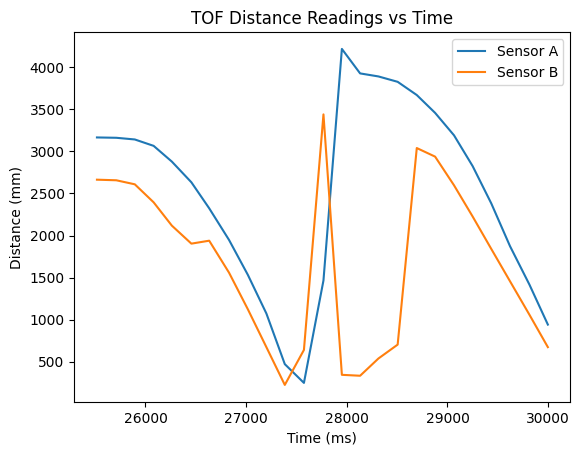

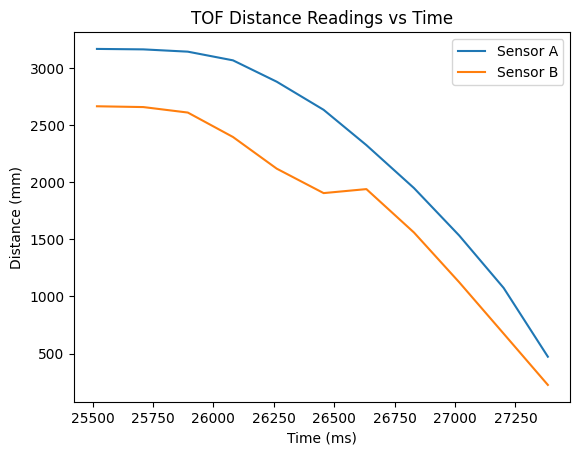

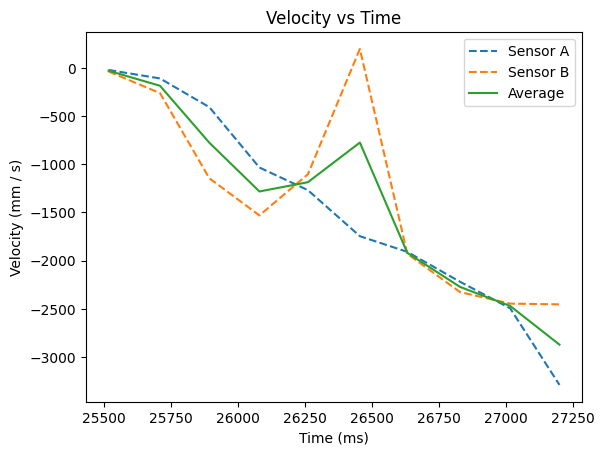

In [3]:
tof = np.load("tof_lab_7.npy")
tof = np.array(tof).astype(float)
plt.plot(tof[:, 0], tof[:, 1])
plt.plot(tof[:, 0], tof[:, 2])
plt.xlabel("Time (ms)")
plt.ylabel("Distance (mm)")
plt.title("TOF Distance Readings vs Time")
plt.legend(["Sensor A", "Sensor B"])
plt.show()
tof =  tof[tof[:, 0] < 27500]
plt.plot(tof[:, 0], tof[:, 1])
plt.plot(tof[:, 0], tof[:, 2])
plt.xlabel("Time (ms)")
plt.ylabel("Distance (mm)")
plt.title("TOF Distance Readings vs Time")
plt.legend(["Sensor A", "Sensor B"])
plt.show()

velocity = np.zeros((tof.shape[0]-1, 5)).astype(float)
velocity[:, 4] = [j-i for i, j in zip(tof[:-1, 0], tof[1:, 0])]
velocity[:, 0] = tof[:-1, 0]
velocity[:, 1] = [((j-i) * 1000.0) / k for i, j, k in zip(tof[:-1, 1], tof[1:, 1], velocity[:, 4])]
velocity[:, 2] = [((j-i) * 1000.0) / k for i, j, k in zip(tof[:-1, 2], tof[1:, 2], velocity[:, 4])]
velocity[:, 3] = [(j+i) / 2 for i, j in zip(velocity[:, 1], velocity[:, 2])]
plt.plot(velocity[:, 0], velocity[:, 1], '--')
plt.plot(velocity[:, 0], velocity[:, 2], '--')
plt.plot(velocity[:, 0], velocity[:, 3])
plt.legend(["Sensor A", "Sensor B", "Average"])
plt.xlabel("Time (ms)")
plt.ylabel("Velocity (mm / s)")
plt.title("Velocity vs Time")
plt.show()

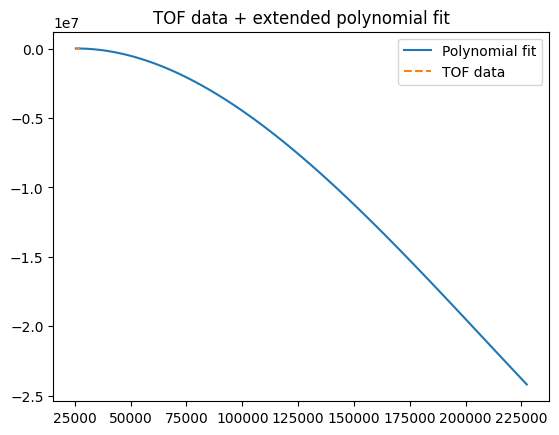

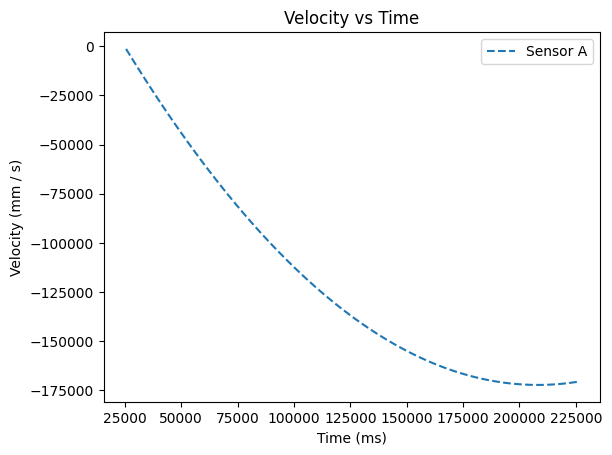

In [73]:
# Fit a polynomial to the TOF data
coefs = poly.polyfit(tof[:, 0], tof[:, 1], 3)
x_new = np.linspace(tof[0, 0], tof[-1, 0] + 200000, num=len(tof[:, 0])*10)
ffit = poly.polyval(x_new, coefs)
plt.plot(x_new, ffit)
plt.plot(tof[:, 0], tof[:, 1], '--')
plt.title("TOF data + extended polynomial fit")
plt.legend(["Polynomial fit", "TOF data"])
plt.show()

velocity = np.zeros((x_new.shape[0]-1, 5)).astype(float)
velocity[:, 4] = [j-i for i, j in zip(x_new[:-1], x_new[1:])]
velocity[:, 0] = x_new[:-1]
velocity[:, 1] = [((j-i) * 1000.0) / k for i, j, k in zip(ffit[:-1], ffit[1:], velocity[:, 4])]
plt.plot(velocity[:, 0], velocity[:, 1], '--')
plt.legend(["Sensor A"])
plt.xlabel("Time (ms)")
plt.ylabel("Velocity (mm / s)")
plt.title("Velocity vs Time")
plt.show()

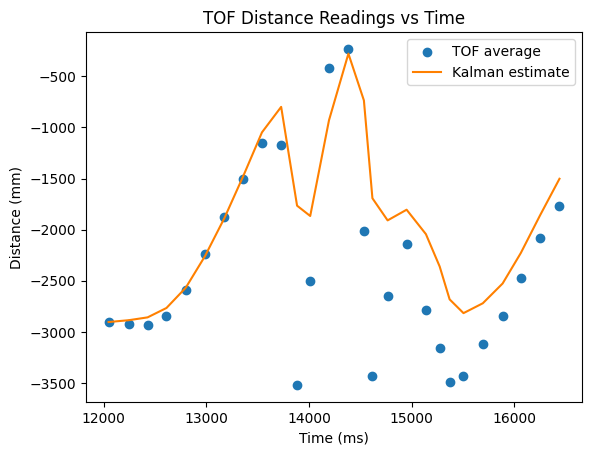

In [4]:
# Load in data
motor_input = np.load("motor_lab_6.npy")
motor_input = (motor_input[:, 1] + motor_input[:, 2]) / 2

tof_output = np.load("tof_lab_6.npy")
# My sensors are at an angle, so adjust for the depth. Also take the average
angle = 13 * math.pi / 180
tof_output[:, 1] = tof_output[:, 1] * np.cos(angle)
tof_output[:, 2] = tof_output[:, 2] * np.cos(angle)
tof_output[:, 1] = (tof_output[:, 1] + tof_output[:, 2]) / 2

# Calculate dynamics matrices
steady_state = 175000
t = 225-25

d = 1/steady_state
m = (-d*0.9*t)/np.log(0.1)

A = np.array([[0, 1], [0, -d/m]])
B = np.array([[0], [1/m]])
C = np.array([[-1,0]])

# This just finds the average sampling time
Delta_T = np.mean(velocity[:, 4]) / 1000.0

# Discritize the dynamics
Ad = np.eye(2) + Delta_T * A
Bd = Delta_T * B

# Set covarience
sig_u = np.array([[10**2,0],[0,10**2]])
sig_z = np.array([[20**2]])

# inital state / uncertainty
sig = np.array([[5**2,0],[0,5**2]])
x = np.array([[-tof_output[0, 1]],[0]])

def kf(mu,sigma,u,y):
    
    mu_p = Ad.dot(mu) + Bd.dot(u) 
    sigma_p = Ad.dot(sigma.dot(Ad.transpose())) + sig_u
    
    
    sigma_m = C.dot(sigma_p.dot(C.transpose())) + sig_z
    kkf_gain = sigma_p.dot(C.transpose().dot(np.linalg.inv(sigma_m)))

    y_m = y-C.dot(mu_p)
    mu = mu_p + kkf_gain.dot(y_m)    
    sigma=(np.eye(2)-kkf_gain.dot(C)).dot(sigma_p)

    return mu,sigma

kf_state = []

#downsample motor inputs to have an equal number of points as the tof readings
R = tof_output.shape[0]
pad_size = math.ceil(float(motor_input.size)/R)*R -motor_input.size
motor_input_padded = np.append(motor_input, np.zeros(pad_size)*np.NaN)
motor_input = np.nanmean(motor_input_padded.reshape(-1,R), axis=0)

# Run the KF
for u, d in zip(motor_input, tof_output[:, 1]):
    x, sig = kf(x, sig, np.array([[u / 130]]), np.array([[d]]))
    kf_state.append(x[:,0])
    
kf_state = np.array(kf_state).astype(float)

plt.scatter(tof_output[:, 0], -tof_output[:, 1])
plt.plot(tof_output[:, 0], kf_state[:, 0], color=[1, 0.5, 0])
plt.legend(["TOF average", "Kalman estimate"])
plt.xlabel("Time (ms)")
plt.ylabel("Distance (mm)")
plt.title("TOF Distance Readings vs Time")
plt.show()